## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### 1. Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
%matplotlib inline

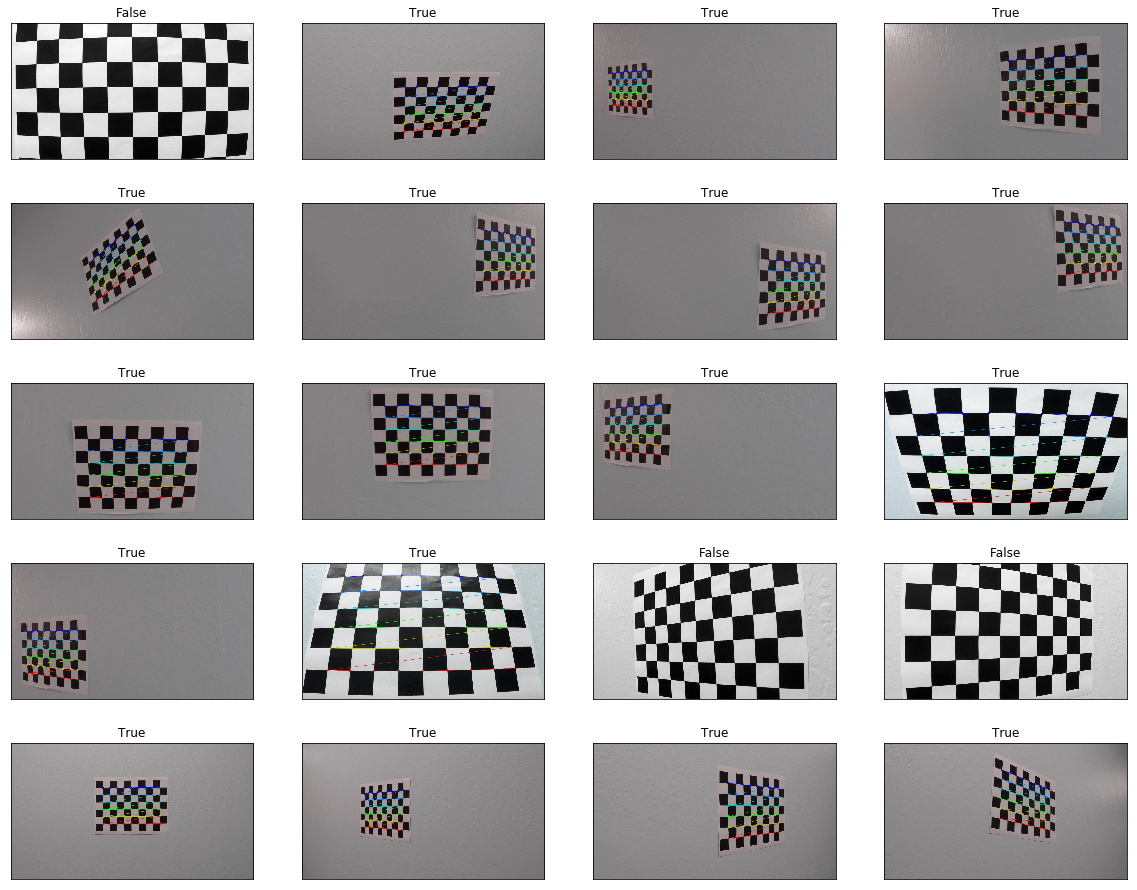

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, ax = plt.subplots(ncols = 4, nrows = 5, figsize = (20, 16))
i = 0
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        r = i % 4
        c = i // 4
        ax[c][r].imshow(img)
        ax[c][r].set_xticks(())
        ax[c][r].set_yticks(())
        ax[c][r].set_title(ret)
        i += 1
    else:
        r = i % 4
        c = i // 4
        ax[c][r].imshow(gray, cmap = 'gray')
        ax[c][r].set_xticks(())
        ax[c][r].set_yticks(())
        ax[c][r].set_title(ret)
        i += 1
# plt.savefig('./output_images/chessboard_corners.jpg')

# Save the chessboard corners result for later use 
if not os.path.exists('./chessboard_corners.p'):
    chessboard_pickle = {}
    chessboard_pickle["objpoints"] = objpoints
    chessboard_pickle["imgpoints"] = imgpoints
    pickle.dump(chessboard_pickle, open( "chessboard_corners.p", "wb" ) )

In [3]:
# Test undistortion on a calibration image
img = cv2.imread('./camera_cal/calibration3.jpg')
def undistort(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    if not os.path.exists('./camera_calibration.p'):
        # Save the camera calibration result for later use
        dist_pickle = {}
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        pickle.dump(dist_pickle, open( "camera_calibration.p", "wb"))

    #Distortion correct the test image
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img
cal_undist = undistort(img, objpoints, imgpoints)
dist_pickle = pickle.load(open( "camera_calibration.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
#cv2.imwrite('./output_images/calibration3_undist.jpg',cal_undist)

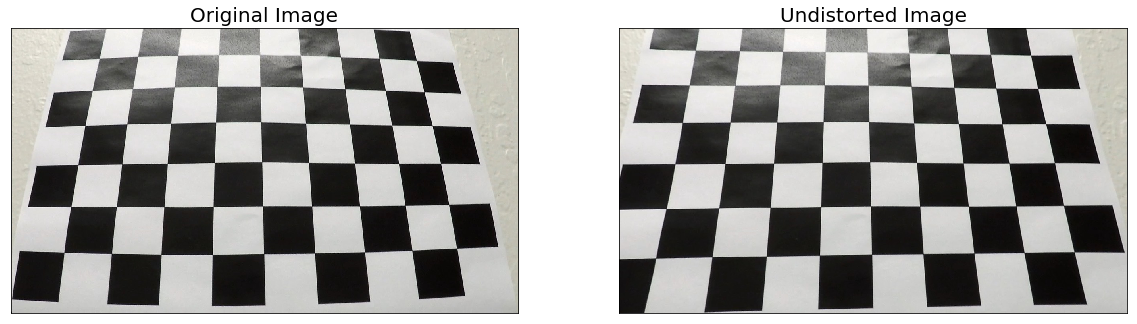

In [4]:
# Visualize undistortion
def visualize_undistort(img, undist_img, image_path, save_img = False):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    #ax1.imshow(img);
    # convert from BGR to RGB for display
    ax1.imshow(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB));
    ax1.set_xticks(())
    ax1.set_yticks(())
    ax1.set_title('Original Image', fontsize=20);
    #ax2.imshow(undist_img);
    ax2.imshow(cv2.cvtColor(undist_img.copy(), cv2.COLOR_BGR2RGB));
    ax2.set_xticks(())
    ax2.set_yticks(())
    ax2.set_title('Undistorted Image', fontsize=20);
    if save_img:
        plt.savefig(image_path)
image_path = './output_images/camera_calibration.jpg'
visualize_undistort(img, cal_undist, image_path, save_img = False)

### 2. Pipeline (Single images)
### 2.1 An example of distortion-corrected image

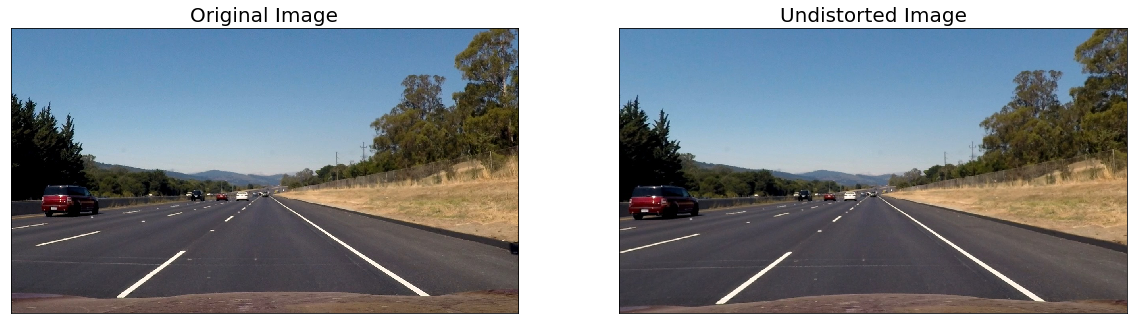

In [5]:
# Test undistortion on a calibration image
img = cv2.imread('./test_images/straight_lines2.jpg')
test_undist = undistort(img, objpoints, imgpoints)
#cv2.imwrite('./test_images/straight_lines1_undist.jpg', test_undist)
image_path = './output_images/straight_lines2_undist.jpg'
visualize_undistort(img, test_undist, image_path, save_img = False)

### 2.2 Binary images to identify lane lines
#### 2.2.1 Sobel Gradient Thresholding

In [6]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # assume input image is grayscale
#     # Convert to grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

#### 2.2.2 Color space thresholding

In [7]:
# Define a function that thresholds the R-channel of BGR
def bgr_select(img, channel = 'r', thresh=(0, 255)):
    if channel == 'r':
        layer = img[:,:,2]
    elif channel == 'g':
        layer = img[:,:,1]
    else:
        layer = img[:,:,0]
    binary_output = np.zeros_like(layer)
    binary_output[(layer > thresh[0]) & (layer <= thresh[1])] = 1
    return layer, binary_output

In [8]:
# Define a function that thresholds the H- & S-channel of HLS
def hls_select(img, channel = 's', thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS) # assuming input img in BGR
    
    if channel == 's':
        layer = hls[:,:,2]
    elif channel == 'l':
        layer = hls[:,:,1]
        #layer = cv2.adaptiveThreshold(layer, 100, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 101, 0)
    else:
        layer = hls[:,:,0]
    
    binary_output = np.zeros_like(layer)
    binary_output[(layer > thresh[0]) & (layer <= thresh[1])] = 1
    return layer, binary_output

### 2.3 Perspective Transform

In [9]:
# Define a function that takes an image, 
# camera matrix and distortion coefficients
def warper(img, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
   
    img_size = (undist.shape[1], undist.shape[0])

    # For source points I choose two points at middle height close to center
    # and two points at the bottom close to the edge
    src = np.float32(
        [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
        [(img_size[0] / 6), img_size[1] - 10],
        [(img_size[0] * 5 / 6), img_size[1] - 10],
        [(img_size[0] / 2 + 62), img_size[1] / 2 + 100]])
    # For destination points, I choose points on top/bottom edges 
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    if not os.path.exists('./perspect_trans_M.p'):
        # Save the camera calibration result for later use
        trans_pickle = {}
        trans_pickle["M"] = M
        trans_pickle["Minv"] = Minv
        pickle.dump(trans_pickle, open( "perspect_trans_M.p", "wb"))

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

    # Return the resulting image and matrix
    return warped


In [ ]:
# Define a temp pipeline that undistorts, converts to binary, and warps
def tmp_pipeline_old(img):
    # Use the OpenCV undistort() function to remove distortion
    img = cv2.undistort(img, mtx, dist, None, mtx)
   
    img_h, hls_binary_h = hls_select(img, channel = 'h', thresh = (20, 100))
    img_s, hls_binary_s = hls_select(img, channel = 's', thresh = (150, 255))
    img_l, hls_binary_l = hls_select(img, channel = 'l', thresh = (200, 255))
    binary_img = np.zeros_like(hls_binary_s)
    binary_img[(hls_binary_h == 1) | (hls_binary_l == 1) | (hls_binary_s == 1)] = 1
    binary_warped = warper(binary_img, mtx, dist)

    return img_h, img_s, img_l, binary_warped

In [61]:
def tmp_pipeline(img):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    img_h, hls_binary_h = hls_select(img, channel = 'h', thresh = (20, 100))
    img_s, hls_binary_s = hls_select(img, channel = 's', thresh = (50, 200))
    img_l, hls_binary_l = hls_select(img, channel = 'l', thresh = (200, 255))
    img_h_warped = warper(hls_binary_h, mtx, dist)
    img_s_warped = warper(hls_binary_s, mtx, dist)
#     img_h_warped = warper(img_h, mtx, dist)
#     img_h_gradx = abs_sobel_thresh(img_h_warped, orient='x', sobel_kernel=21, thresh=(10, 80))
    img_l_warped = warper(img_l, mtx, dist)
    img_l_gradx = abs_sobel_thresh(img_l_warped, orient='x', sobel_kernel=21, thresh=(15, 100))
    img_s_warped = warper(img_s, mtx, dist)
    img_s_gradx = abs_sobel_thresh(img_s_warped, orient='x', sobel_kernel=21, thresh=(15, 100))

    binary_img = np.zeros_like(hls_binary_s)
#     binary_img[(hls_binary_h == 1) | (hls_binary_s == 1) | (img_l_gradx == 1)] = 1
#     binary_warped = warper(binary_img, mtx, dist)
    binary_img[(img_h_warped == 1) | (img_s_gradx == 1) | (img_l_gradx == 1) | (img_s_warped == 1)] = 1
    return img_h_warped, img_s_gradx, img_l_gradx, binary_img

[]

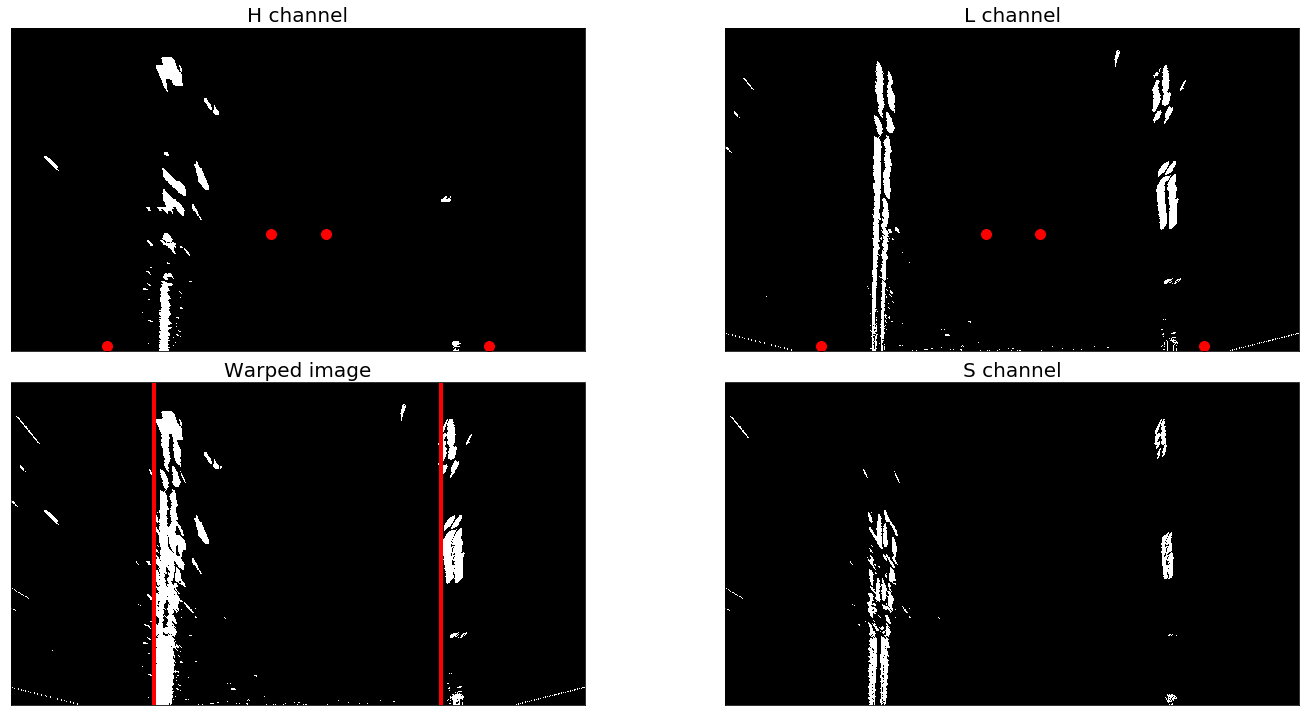

In [89]:
# run the temp pipeline
img = cv2.imread('./images006.jpeg')
img_size = (img.shape[1], img.shape[0])
# img_h, img_s, img_l, binary_warped = tmp_pipeline(img)
hls_binary_h, hls_binary_s, img_l_gradx, binary_warped = tmp_pipeline(img)

# Plot the result
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(20, 10))
fig.tight_layout()
#ax[0][0].imshow(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB))
# img_h_warped = warper(img_h, mtx, dist)
ax[0][0].imshow(hls_binary_h, cmap = 'gray')
ax[0][0].plot([img_size[0] / 2 - 60], [img_size[1] / 2 + 100], 'ro', markersize = 10)
ax[0][0].plot([img_size[0] / 2 + 62], [img_size[1] / 2 + 100], 'ro', markersize = 10)
ax[0][0].plot([img_size[0] / 6], [img_size[1] - 10], 'ro', markersize = 10)
ax[0][0].plot([img_size[0] * 5 / 6], [img_size[1] - 10], 'ro', markersize = 10)
#ax[0][0].set_title('Original Image', fontsize=20
ax[0][0].set_title('H channel', fontsize=20)
ax[0][0].set_xticks(())
ax[0][0].set_yticks(())

#ax[0][1].imshow(cv2.cvtColor(img_l.copy(), cv2.COLOR_BGR2RGB))
# img_l_warped = warper(img_l, mtx, dist)
# img_l_gradx = abs_sobel_thresh(img_l_warped, orient='x', sobel_kernel=21, thresh=(20, 255))
ax[0][1].imshow(img_l_gradx, cmap = 'gray')
ax[0][1].plot([img_size[0] / 2 - 60], [img_size[1] / 2 + 100], 'ro', markersize = 10)
ax[0][1].plot([img_size[0] / 2 + 62], [img_size[1] / 2 + 100], 'ro', markersize = 10)
ax[0][1].plot([img_size[0] / 6], [img_size[1] - 10], 'ro', markersize = 10)
ax[0][1].plot([img_size[0] * 5 / 6], [img_size[1] - 10], 'ro', markersize = 10)
ax[0][1].set_title('L channel', fontsize=20)
ax[0][1].set_xticks(())
ax[0][1].set_yticks(())

# ax[1].imshow(cv2.cvtColor(warped_img.copy(), cv2.COLOR_BGR2RGB))
ax[1][0].imshow(binary_warped, cmap = 'gray')
ax[1][0].axvline(x = img_size[0] / 4, color = 'r', linewidth = 4)
ax[1][0].axvline(x = img_size[0] * 3 / 4, color = 'r', linewidth = 4)
ax[1][0].set_title('Warped image', fontsize=20)
ax[1][0].set_xticks(())
ax[1][0].set_yticks(())
#plt.savefig('./output_images/test6_binary_perspective_trans.jpg')

#img_l_th = cv2.adaptiveThreshold(img_l, 100, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 101, 0)
# img_s_warped = warper(img_s, mtx, dist)
# img_s_gradx = abs_sobel_thresh(img_s_warped, orient='x', sobel_kernel=21, thresh=(20, 255))
ax[1][1].imshow(hls_binary_s, cmap = 'gray')
#ax[1][1].axvline(x = img_size[0] / 4, color = 'r', linewidth = 4)
#ax[1][1].axvline(x = img_size[0] * 3 / 4, color = 'r', linewidth = 4)
ax[1][1].set_title('S channel', fontsize=20)
ax[1][1].set_xticks(())
ax[1][1].set_yticks(())

### 2.4 Calculate curvature
#### 2.4.1 Finding the lanes: sliding window maximum

In [ ]:
# # check the bottom half of the image for lane lines peak
# histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# plt.plot(histogram)

In [18]:
# Define a function that takes a warped binary image and fit quadratic function to the lane lines
def fit_poly(binary_warped, left_fit = None, right_fit = None, cold_start = True):
    if cold_start:
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = binary_warped.shape[0] // nwindows
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 20
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
    return left_fit, right_fit

In [ ]:
# left_fit, right_fit = fit_poly(binary_warped)

In [19]:
def get_curvature(binary_warped, left_fit, right_fit):

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    y_eval = np.max(ploty)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

#     print('Curvature of the left lane is {:.2f} m'.format(left_curverad))
#     print('Curvature of the right lane is {:.2f} m'.format(right_curverad))
    
    curverad = np.mean([left_curverad, right_curverad])
    
    lane_center = (left_fitx[binary_warped.shape[0]-1] + right_fitx[binary_warped.shape[0]-1]) / 2.
    camera_center = binary_warped.shape[1] / 2.
    v_off_center = abs(lane_center - camera_center) * xm_per_pix
    
    return curverad, v_off_center

In [ ]:
# # Generate x and y values for plotting
# ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0] )
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
# #color left lane to red, color right lane to blue
# out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
# fig, ax = plt.subplots(figsize = (16, 9))
# plt.imshow(out_img)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)
# plt.xticks(());
# plt.yticks(());

#### 2.4.3 Fit a polynomial

In [ ]:
# # Assume you now have a new warped binary image 
# # from the next frame of video (also called "binary_warped")
# # It's now much easier to find line pixels!
# nonzero = binary_warped.nonzero()
# nonzeroy = np.array(nonzero[0])
# nonzerox = np.array(nonzero[1])
# margin = 100
# left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
# left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
# left_fit[1]*nonzeroy + left_fit[2] + margin))) 

# right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
# right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
# right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# # Again, extract left and right line pixel positions
# leftx = nonzerox[left_lane_inds]
# lefty = nonzeroy[left_lane_inds] 
# rightx = nonzerox[right_lane_inds]
# righty = nonzeroy[right_lane_inds]
# # Fit a second order polynomial to each
# left_fit = np.polyfit(lefty, leftx, 2)
# right_fit = np.polyfit(righty, rightx, 2)
# # Generate x and y values for plotting
# ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [ ]:
# # Create an image to draw on and an image to show the selection window
# out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# window_img = np.zeros_like(out_img)
# # Color in left and right line pixels
# out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# # Generate a polygon to illustrate the search window area
# # And recast the x and y points into usable format for cv2.fillPoly()
# left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
# left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
#                               ploty])))])
# left_line_pts = np.hstack((left_line_window1, left_line_window2))
# right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
# right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
#                               ploty])))])
# right_line_pts = np.hstack((right_line_window1, right_line_window2))

# # Draw the lane onto the warped blank image
# cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
# cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
# result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
# # plt.imshow(result)
# # plt.plot(left_fitx, ploty, color='yellow')
# # plt.plot(right_fitx, ploty, color='yellow')
# # plt.xlim(0, 1280)
# # plt.ylim(720, 0)
# fig, ax = plt.subplots(figsize = (16, 9))
# plt.imshow(result)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)
# plt.xticks(());
# plt.yticks(());

In [87]:
# Define a pipeline 
def pipeline(img):
    # Use the OpenCV undistort() function to remove distortion
    img = cv2.undistort(img, mtx, dist, None, mtx)
   
#     hls_binary_h = hls_select(img, channel = 'h', thresh = (20, 100))
#     hls_binary_s = hls_select(img, channel = 's', thresh = (120, 255))
#     hls_binary_l = hls_select(img, channel = 'l', thresh = (200, 255))
#     binary_img = np.zeros_like(hls_binary_s)
#     binary_img[(hls_binary_h == 1) | (hls_binary_l == 1) | (hls_binary_s == 1)] = 1
#     binary_warped = warper(binary_img, mtx, dist)

#     img_h, hls_binary_h = hls_select(img, channel = 'h', thresh = (20, 100))
#     img_s, hls_binary_s = hls_select(img, channel = 's', thresh = (150, 255))
#     img_l, hls_binary_l = hls_select(img, channel = 'l', thresh = (200, 255))
#     img_h_warped = warper(hls_binary_h, mtx, dist)
#     img_s_warped = warper(hls_binary_s, mtx, dist)
#     img_l_warped = warper(img_l, mtx, dist)
#     img_l_gradx = abs_sobel_thresh(img_l_warped, orient='x', sobel_kernel=21, thresh=(10, 80))
#     binary_img = np.zeros_like(hls_binary_s)
#     binary_img[(img_h_warped == 1) | (img_s_warped == 1) | (img_l_gradx == 1)] = 1
#     binary_warped = binary_img.copy()
    
    
    img_h, hls_binary_h = hls_select(img, channel = 'h', thresh = (20, 100))
    img_s, hls_binary_s = hls_select(img, channel = 's', thresh = (50, 200))
    img_l, hls_binary_l = hls_select(img, channel = 'l', thresh = (200, 255))
    img_h_warped = warper(hls_binary_h, mtx, dist)
    img_s_warped = warper(hls_binary_s, mtx, dist)
#     img_h_warped = warper(img_h, mtx, dist)
#     img_h_gradx = abs_sobel_thresh(img_h_warped, orient='x', sobel_kernel=21, thresh=(10, 80))
    img_l_warped = warper(img_l, mtx, dist)
    img_l_gradx = abs_sobel_thresh(img_l_warped, orient='x', sobel_kernel=21, thresh=(15, 100))
    img_s_warped = warper(img_s, mtx, dist)
    img_s_gradx = abs_sobel_thresh(img_s_warped, orient='x', sobel_kernel=21, thresh=(15, 100))

    binary_img = np.zeros_like(hls_binary_s)
#     binary_img[(hls_binary_h == 1) | (hls_binary_s == 1) | (img_l_gradx == 1)] = 1
#     binary_warped = warper(binary_img, mtx, dist)
    binary_img[(img_h_warped == 1) | (img_s_gradx == 1) | (img_l_gradx == 1) | (img_s_warped == 1)] = 1
    
    left_fit, right_fit = fit_poly(binary_warped)
    lane_curv, v_off_center = get_curvature(binary_warped, left_fit, right_fit)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    img = np.zeros((512,512,3), np.uint8)

    # Write some Text
    font = cv2.FONT_HERSHEY_SIMPLEX
    topLeftCorner1 = (10,100)
    topLeftCorner2 = (10,200)
    fontScale              = 2
    fontColor              = (255,255,255)
    lineType               = 8

    curv_message = 'Curvature of the Road is {:.2f} m.'.format(lane_curv) 
    cntr_message = 'Vehicle is off center by {:.2f} m'.format(v_off_center)
    cv2.putText(result, curv_message, 
        topLeftCorner1, 
        font, 
        fontScale,
        fontColor,
        lineType)
    cv2.putText(result, cntr_message, 
        topLeftCorner2, 
        font, 
        fontScale,
        fontColor,
        lineType)

    return result

[]

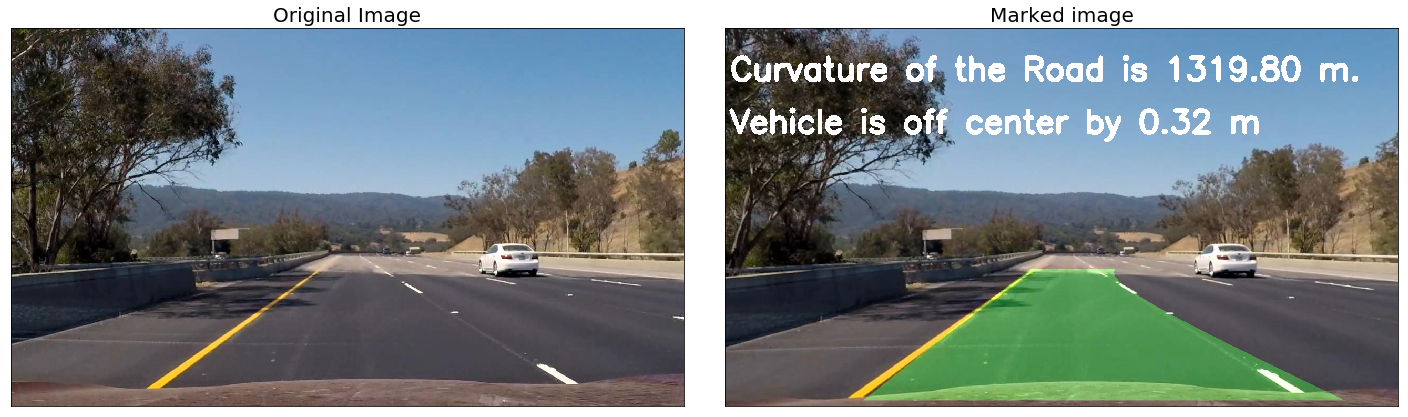

In [88]:
trans_pickle = pickle.load(open("perspect_trans_M.p", "rb"))

M = trans_pickle["M"]
Minv = trans_pickle["Minv"]

img = cv2.imread('./images006.jpeg')
result = pipeline(img)
# # Create an image to draw the lines on
# warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
# color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# # Recast the x and y points into usable format for cv2.fillPoly()
# pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
# pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
# pts = np.hstack((pts_left, pts_right))

# # Draw the lane onto the warped blank image
# cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# # Warp the blank back to original image space using inverse perspective matrix (Minv)
# newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# # Combine the result with the original image
# result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 10))
fig.tight_layout()
ax[0].imshow(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image', fontsize=20)
ax[0].set_xticks(())
ax[0].set_yticks(())
ax[1].imshow(cv2.cvtColor(result.copy(), cv2.COLOR_BGR2RGB))
ax[1].set_title('Marked image', fontsize=20)
ax[1].set_xticks(())
ax[1].set_yticks(())
#plt.savefig('./output_images/test6_binary_perspective_trans.jpg')

In [108]:
import collections

class LaneFinder():
    def __init__(self):
        # values of quadratic fit of the previous 10 frames
        self.prev_frames_left = collections.deque(maxlen = 10)
        self.prev_frames_right = collections.deque(maxlen = 10)
        
        # quadratic fit averaged over the previous 10 frames
        self.avg_fit_left = None
        self.avg_fit_right = None
        
        # keep account of frame number
        self.frameNum = 0
        
    def pipeline_function(self, frame):
        # Use the OpenCV undistort() function to remove distortion
        img = cv2.undistort(frame, mtx, dist, None, mtx)

#         hls_binary_h = hls_select(img, channel = 'h', thresh = (20, 100))
#         hls_binary_s = hls_select(img, channel = 's', thresh = (120, 255))
#         hls_binary_l = hls_select(img, channel = 'l', thresh = (200, 255))
#         binary_img = np.zeros_like(hls_binary_s)
#         binary_img[(hls_binary_h == 1) | (hls_binary_l == 1) | (hls_binary_s == 1)] = 1
#         binary_warped = warper(binary_img, mtx, dist)

#         img_h, hls_binary_h = hls_select(img, channel = 'h', thresh = (20, 100))
#         img_s, hls_binary_s = hls_select(img, channel = 's', thresh = (150, 255))
#         img_l, hls_binary_l = hls_select(img, channel = 'l', thresh = (200, 255))
#         img_h_warped = warper(hls_binary_h, mtx, dist)
#         img_s_warped = warper(hls_binary_s, mtx, dist)
#         img_l_warped = warper(img_l, mtx, dist)
#         img_l_gradx = abs_sobel_thresh(img_l_warped, orient='x', sobel_kernel=21, thresh=(10, 80))
#         binary_img = np.zeros_like(hls_binary_s)
#         binary_img[(img_h_warped == 1) | (img_s_warped == 1) | (img_l_gradx == 1)] = 1

        img_h, hls_binary_h = hls_select(img, channel = 'h', thresh = (20, 100))
        img_s, hls_binary_s = hls_select(img, channel = 's', thresh = (50, 200))
        img_l, hls_binary_l = hls_select(img, channel = 'l', thresh = (200, 255))
        img_h_warped = warper(hls_binary_h, mtx, dist)
        img_s_warped = warper(hls_binary_s, mtx, dist)
        img_l_warped = warper(img_l, mtx, dist)
        img_l_gradx = abs_sobel_thresh(img_l_warped, orient='x', sobel_kernel=21, thresh=(15, 100))
        img_s_warped = warper(img_s, mtx, dist)
        img_s_gradx = abs_sobel_thresh(img_s_warped, orient='x', sobel_kernel=21, thresh=(15, 100))

        binary_img = np.zeros_like(hls_binary_s)
    #     binary_img[(hls_binary_h == 1) | (hls_binary_s == 1) | (img_l_gradx == 1)] = 1
    #     binary_warped = warper(binary_img, mtx, dist)
        binary_img[(img_h_warped == 1) | (img_s_gradx == 1) | (img_s_warped == 1) | (img_l_gradx == 1)] = 1


        binary_warped = binary_img.copy()
        if self.frameNum == 0:
        #if 1 == 1:
            left_fit, right_fit = fit_poly(binary_warped)
        else:
            left_fit, right_fit = fit_poly(binary_warped, self.avg_fit_left, self.avg_fit_right, cold_start = False)
            
        self.prev_frames_left.append(left_fit)
        self.prev_frames_right.append(right_fit)
        self.avg_fit_left = np.mean(self.prev_frames_left, axis = 0)
        self.avg_fit_right = np.mean(self.prev_frames_right, axis = 0)
        
        left_fit = self.avg_fit_left
        right_fit = self.avg_fit_right
        
        lane_curv, v_off_center = get_curvature(binary_warped, left_fit, right_fit)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

        img = np.zeros((512,512,3), np.uint8)

        # Write some Text
        font = cv2.FONT_HERSHEY_SIMPLEX
        topLeftCorner1 = (10,100)
        topLeftCorner2 = (10,200)
        fontScale              = 2
        fontColor              = (255,255,255)
        lineType               = 8

        curv_message = 'Curvature of the Road is {:.2f} m.'.format(lane_curv) 
        cntr_message = 'Vehicle is off center by {:.2f} m.'.format(v_off_center)
        cv2.putText(result, curv_message, topLeftCorner1, font, fontScale, fontColor, lineType)
        cv2.putText(result, cntr_message, topLeftCorner2, font, fontScale, fontColor, lineType)

        self.frameNum += 1
        return result

In [109]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [111]:
output_dir = "test_videos_output/"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

video_processor = LaneFinder()

clip1 = VideoFileClip("project_video.mp4")
#clip_out = clip1.to_images_sequence("images%03d.jpeg")
clip_out = clip1.fl_image(video_processor.pipeline_function) #NOTE: this function expects color images!!
%time clip_out.write_videofile(output_dir + 'project_out5.mp4', audio=False)

[MoviePy] >>>> Building video test_videos_output/project_out5.mp4
[MoviePy] Writing video test_videos_output/project_out5.mp4



 12%|█▏        | 152/1261 [00:55<07:02,  2.62it/s]


 24%|██▍       | 303/1261 [01:51<05:40,  2.81it/s]


 36%|███▌      | 454/1261 [02:46<05:12,  2.58it/s]


 48%|████▊     | 605/1261 [03:41<04:03,  2.70it/s]


 60%|█████▉    | 756/1261 [04:37<03:02,  2.77it/s]


 72%|███████▏  | 907/1261 [05:30<02:09,  2.74it/s]


 84%|████████▍ | 1057/1261 [06:28<01:22,  2.46it/s]


 96%|█████████▌| 1205/1261 [07:23<00:20,  2.77it/s]


100%|█████████▉| 1260/1261 [07:43<00:00,  2.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_out5.mp4 

CPU times: user 9min 33s, sys: 45.3 s, total: 10min 19s
Wall time: 7min 44s


In [ ]:
# output_dir = "test_videos_output/"
# if not os.path.exists(output_dir):
#     os.mkdir(output_dir)
# # white_output = 'test_videos_output/solidWhiteRight.mp4'
# ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
# ## To do so add .subclip(start_second,end_second) to the end of the line below
# ## Where start_second and end_second are integer values representing the start and end of the subclip
# ## You may also uncomment the following line for a subclip of the first 5 seconds
# #clip1 = VideoFileClip("project_video.mp4").subclip(0.,1.)
# clip1 = VideoFileClip("project_video.mp4")
# clip_out = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
# %time clip_out.write_videofile(output_dir + 'clip_out2.mp4', audio=False)